In [2]:
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)


2023-12-12 23:21:12.871936: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 23:21:13.021831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 23:21:13.021892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 23:21:13.043608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 23:21:13.090692: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 23:21:13.092057: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
df = df[5::6]

df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [4]:
temp = df[
    'T (degC)'
]


In [5]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)


WINDOW_SIZE = 5

X, y = df_to_X_y(temp, WINDOW_SIZE)

In [6]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]

X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [7]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         


2023-12-12 23:21:17.266477: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-12 23:21:17.266511: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: omen15
2023-12-12 23:21:17.266517: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: omen15
2023-12-12 23:21:17.266691: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 470.223.2
2023-12-12 23:21:17.266713: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-12 23:21:17.266718: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 470.223.2


                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# the only the lowest validation lost
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(
    learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model1.fit(X_train, y_train, validation_data=(
    X_val, y_val), epochs=10, callbacks=[cp])


model1 = load_model('model1/')

Epoch 1/10
1857/1875 [============================>.] - ETA: 0s - loss: 53.2462 - root_mean_squared_error: 7.2970INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 9s 4ms/step - loss: 52.7954 - root_mean_squared_error: 7.2660 - val_loss: 1.7754 - val_root_mean_squared_error: 1.3325
Epoch 2/10
1863/1875 [============================>.] - ETA: 0s - loss: 3.0265 - root_mean_squared_error: 1.7397INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 8s 4ms/step - loss: 3.0145 - root_mean_squared_error: 1.7362 - val_loss: 0.7257 - val_root_mean_squared_error: 0.8519
Epoch 3/10
1861/1875 [============================>.] - ETA: 0s - loss: 1.0909 - root_mean_squared_error: 1.0444INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 8s 4ms/step - loss: 1.0886 - root_mean_squared_error: 1.0433 - val_loss: 0.5938 - val_root_mean_squared_error: 0.7706
Epoch 4/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.7820 - root_mean_squared_error: 0.8843INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.7816 - root_mean_squared_error: 0.8841 - val_loss: 0.5360 - val_root_mean_squared_error: 0.7321
Epoch 5/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.7001 - root_mean_squared_error: 0.8367INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.7005 - root_mean_squared_error: 0.8370 - val_loss: 0.5143 - val_root_mean_squared_error: 0.7172
Epoch 6/10
1862/1875 [============================>.] - ETA: 0s - loss: 0.6728 - root_mean_squared_error: 0.8203INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6724 - root_mean_squared_error: 0.8200 - val_loss: 0.4982 - val_root_mean_squared_error: 0.7058
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6598 - root_mean_squared_error: 0.8123 - val_loss: 0.4986 - val_root_mean_squared_error: 0.7061
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6542 - root_mean_squared_error: 0.8088 - val_loss: 0.5035 - val_root_mean_squared_error: 0.7096
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6496 - root_mean_squared_error: 0.8060INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6496 - root_mean_squared_error: 0.8060 - val_loss: 0.4901 - val_root_mean_squared_error: 0.7001
Epoch 10/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6468 - root_mean_squared_error: 0.8043INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6464 - root_mean_squared_error: 0.8040 - val_loss: 0.4873 - val_root_mean_squared_error: 0.6981


1875/1875 [==============================] - 4s 2ms/step


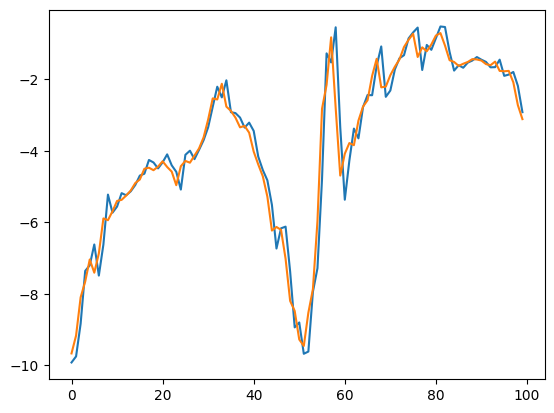

157/157 [==============================] - 1s 2ms/step


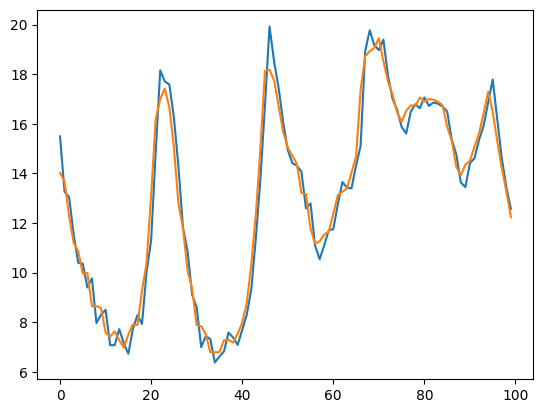

159/159 [==============================] - 0s 2ms/step


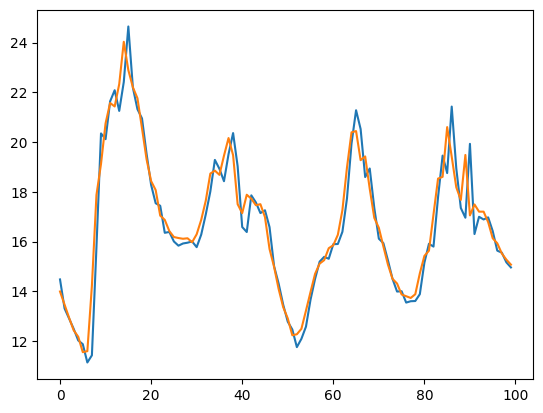

In [9]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(
    data={'Train Predictions': train_predictions, 'Actuals': y_train})

plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.show()

############ validation results ############
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(
    data={'Val Predictions': val_predictions, 'Actuals': y_val})

plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.show()

############ test results ############
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(
    data={'Test Predictions': test_predictions, 'Actuals': y_test})

plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.show()